In [3]:
import requests
from bs4 import BeautifulSoup
import csv
import json


def getHTMLtext(url):
    """请求获得网页内容"""
    try:
        r = requests.get(url, timeout=30)
        r.raise_for_status()
        r.encoding = r.apparent_encoding
        print("成功访问")
        return r.text
    except:
        print("访问错误")
        return " "


def get_content(html):
    """处理得到有用信息保存数据文件"""
    final = []  # 初始化一个列表保存数据
    bs = BeautifulSoup(html, "html.parser")  # 创建BeautifulSoup对象
    body = bs.body
    data = body.find('div', {'id': '7d'})  # 找到div标签且id = 7d
    # 下面爬取当天的数据
    data2 = body.find_all('div', {'class': 'left-div'})
    text = data2[2].find('script').string
    text = text[text.index('=') + 1:-2]  # 移除改var data=将其变为json数据
    jd = json.loads(text)
    dayone = jd['od']['od2']  # 找到当天的数据
    final_day = []  # 存放当天的数据
    count = 0
    for i in dayone:
        temp = []
        if count <= 23:
            temp.append(i['od21'])  # 添加时间
            temp.append(i['od22'])  # 添加当前时刻温度
            temp.append(i['od24'])  # 添加当前时刻风力方向
            temp.append(i['od25'])  # 添加当前时刻风级
            temp.append(i['od26'])  # 添加当前时刻降水量
            temp.append(i['od27'])  # 添加当前时刻相对湿度
            temp.append(i['od28'])  # 添加当前时刻控制质量
            # print(temp)
            final_day.append(temp)
        count = count + 1
    # 下面爬取7天的数据
    ul = data.find('ul')  # 找到所有的ul标签
    li = ul.find_all('li')  # 找到左右的li标签
    i = 0  # 控制爬取的天数
    for day in li:  # 遍历找到的每一个li
        if i < 7 and i > 0:
            temp = []  # 临时存放每天的数据
            date = day.find('h1').string  # 得到日期
            date = date[0:date.index('日')]  # 取出日期号
            temp.append(date)
            inf = day.find_all('p')  # 找出li下面的p标签,提取第一个p标签的值，即天气
            temp.append(inf[0].string)

            tem_low = inf[1].find('i').string  # 找到最低气温

            if inf[1].find('span') is None:  # 天气预报可能没有最高气温
                tem_high = None
            else:
                tem_high = inf[1].find('span').string  # 找到最高气温
            temp.append(tem_low[:-1])
            if tem_high[-1] == '℃':
                temp.append(tem_high[:-1])
            else:
                temp.append(tem_high)

            wind = inf[2].find_all('span')  # 找到风向
            for j in wind:
                temp.append(j['title'])

            wind_scale = inf[2].find('i').string  # 找到风级
            index1 = wind_scale.index('级')
            temp.append(int(wind_scale[index1 - 1:index1]))
            final.append(temp)
        i = i + 1
    return final_day, final


# print(final)
def get_content2(html):
    """处理得到有用信息保存数据文件"""
    final = []  # 初始化一个列表保存数据
    bs = BeautifulSoup(html, "html.parser")  # 创建BeautifulSoup对象
    body = bs.body
    data = body.find('div', {'id': '15d'})  # 找到div标签且id = 15d
    ul = data.find('ul')  # 找到所有的ul标签
    li = ul.find_all('li')  # 找到左右的li标签
    final = []
    i = 0  # 控制爬取的天数
    for day in li:  # 遍历找到的每一个li
        if i < 8:
            temp = []  # 临时存放每天的数据
            date = day.find('span', {'class': 'time'}).string  # 得到日期
            date = date[date.index('（') + 1:-2]  # 取出日期号
            temp.append(date)
            weather = day.find('span', {'class': 'wea'}).string  # 找到天气
            temp.append(weather)
            tem = day.find('span', {'class': 'tem'}).text  # 找到温度
            temp.append(tem[tem.index('/') + 1:-1])  # 找到最低气温
            temp.append(tem[:tem.index('/') - 1])  # 找到最高气温
            wind = day.find('span', {'class': 'wind'}).string  # 找到风向
            if '转' in wind:  # 如果有风向变化
                temp.append(wind[:wind.index('转')])
                temp.append(wind[wind.index('转') + 1:])
            else:  # 如果没有风向变化，前后风向一致
                temp.append(wind)
                temp.append(wind)
            wind_scale = day.find('span', {'class': 'wind1'}).string  # 找到风级
            index1 = wind_scale.index('级')
            temp.append(int(wind_scale[index1 - 1:index1]))

            final.append(temp)
    return final


def write_to_csv(file_name, data, day=14):
    """保存为csv文件"""
    with open(file_name, 'a', errors='ignore', newline='') as f:
        if day == 14:
            header = ['日期', '天气', '最低气温', '最高气温', '风向1', '风向2', '风级']
        else:
            header = ['小时', '温度', '风力方向', '风级', '降水量', '相对湿度', '空气质量']
        f_csv = csv.writer(f)
        f_csv.writerow(header)
        f_csv.writerows(data)


def main():
    """主函数"""
    print("Weather test")
    #
    url1 = 'http://www.weather.com.cn/weather/101180701.shtml'  # 7天天气中国天气网 - 河南南阳
    url2 = 'http://www.weather.com.cn/weather15d/101180701.shtml'  # 8-15天天气中国天气网 - 河南南阳

    html1 = getHTMLtext(url1)
    data1, data1_7 = get_content(html1)  # 获得1-7天和当天的数据

    html2 = getHTMLtext(url2)
    data8_14 = get_content2(html2)  # 获得8-14天数据
    data14 = data1_7 + data8_14
    # print(data)
    write_to_csv('weather14.csv', data14, 14)  # 保存为csv文件
    write_to_csv('weather1.csv', data1, 1)


if __name__ == '__main__':
    main()


Weather test
成功访问
成功访问


In [133]:
import csv
tmp_lst=[]
with open('weather1.csv','r') as f:
    reader = csv.reader(f)
    print(type(reader))
    
    for row in reader:
        print(row)
        tmp_lst.append(row)
df1 = pd.DataFrame(tmp_lst[1:],columns=tmp_lst[0])
print(df1)

<class '_csv.reader'>
['小时', '温度', '风力方向', '风级', '降水量', '相对湿度', '空气质量']
['17', '6', '西南风', '2', '0', '86', '170']
['16', '5', '西风', '2', '0', '87', '175']
['15', '4', '西南风', '3', '0', '89', '188']
['14', '4', '西南风', '3', '0', '85', '170']
['13', '5', '西南风', '3', '0', '80', '193']
['12', '5', '西南风', '1', '0', '75', '178']
['11', '4', '东北风', '1', '0', '77', '180']
['10', '4', '东风', '2', '0', '80', '182']
['9', '3', '东风', '1', '0', '83', '172']
['8', '3', '北风', '1', '0', '82', '182']
['7', '3', '东北风', '1', '0', '77', '188']
['6', '3', '东北风', '2', '0', '78', '179']
['5', '4', '东北风', '2', '0', '76', '176']
['4', '4', '东北风', '2', '0', '76', '175']
['3', '4', '东北风', '2', '0', '75', '173']
['2', '3', '东北风', '2', '0', '78', '173']
['1', '3', '北风', '2', '0', '85', '148']
['0', '3', '北风', '3', '0', '83', '145']
['23', '2', '北风', '3', '0.1', '89', '147']
['22', '2', '北风', '3', '0.3', '90', '153']
['21', '2', '北风', '3', '0.3', '89', '192']
['20', '2', '北风', '3', '0.4', '88', '230']
['19', '3', '东北风

In [28]:
tmp_lst14=[]
with open('weather14.csv','r') as f14:
    reader14 = csv.reader(f14)
    print(type(reader14))
    
    for row in reader14:
        print(row)
        tmp_lst14.append(row)
df14 = pd.DataFrame(tmp_lst14[1:],columns=tmp_lst14[0])
print(df14)

<class '_csv.reader'>
['日期', '天气', '最低气温', '最高气温', '风向1', '风向2', '风级']
['26', '多云', '0', '13', '东北风', '东北风', '3']
['27', '阴', '0', '9', '东北风', '西北风', '3']
['28', '多云转晴', '-2', '11', '北风', '东风', '3']
['29', '多云转阴', '0', '10', '西南风', '西南风', '4']
['30', '多云转晴', '0', '13', '南风', '西南风', '3']
['31', '多云转阴', '2', '14', '南风', '西北风', '3']
['1', '阴转晴', '1', '15', '西南风', '西南风', '3']
['2', '多云转阴', '1', '12', '西南风', '东北风', '3']
['3', '阴转多云', '1', '13', '东北风', '西风', '3']
['4', '阴转晴', '1', '18', '东南风', '西风', '3']
['5', '阴', '6', '19', '西南风', '西风', '3']
['6', '多云转晴', '8', '21', '西南风', '西南风', '3']
['7', '晴转多云', '8', '21', '南风', '西南风', '3']
['8', '阴', '12', '21', '西风', '东北风', '3']
    日期    天气 最低气温 最高气温  风向1  风向2 风级
0   26    多云    0   13  东北风  东北风  3
1   27     阴    0    9  东北风  西北风  3
2   28  多云转晴   -2   11   北风   东风  3
3   29  多云转阴    0   10  西南风  西南风  4
4   30  多云转晴    0   13   南风  西南风  3
5   31  多云转阴    2   14   南风  西北风  3
6    1   阴转晴    1   15  西南风  西南风  3
7    2  多云转阴    1   12  西南风  东北风  3
8   

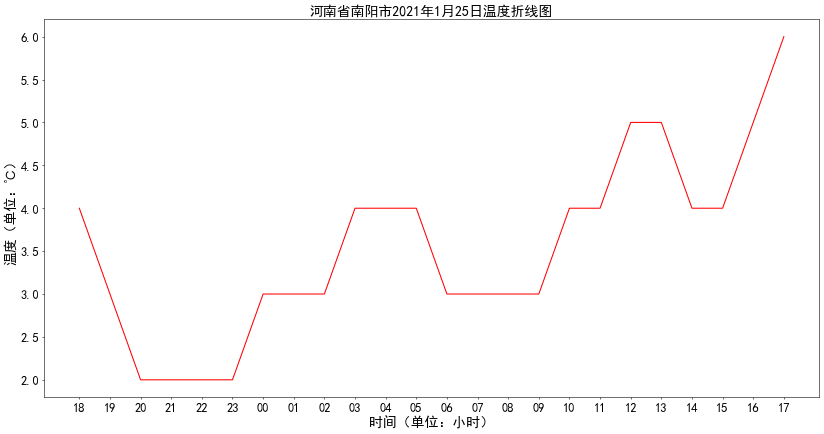

In [124]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
plt.rcParams['font.sans-serif']=['SimHei']
plt.rcParams['axes.unicode_minus'] = False
fig = plt.figure(figsize=(20,10),dpi=50) 

x= list(df1["小时"])
y= list(df1["温度"])

y=list(map(int,y))#将字符串改为int
plt.gca().invert_xaxis()#对x轴翻转

plt.tick_params(labelsize=18)
plt.plot(x,y,"r")

plt.xlabel("时间（单位：小时）",fontsize=20)
plt.ylabel("温度（单位：℃）",fontsize=20)
plt.title("河南省南阳市2021年1月25日温度折线图",fontsize=20)
plt.show()

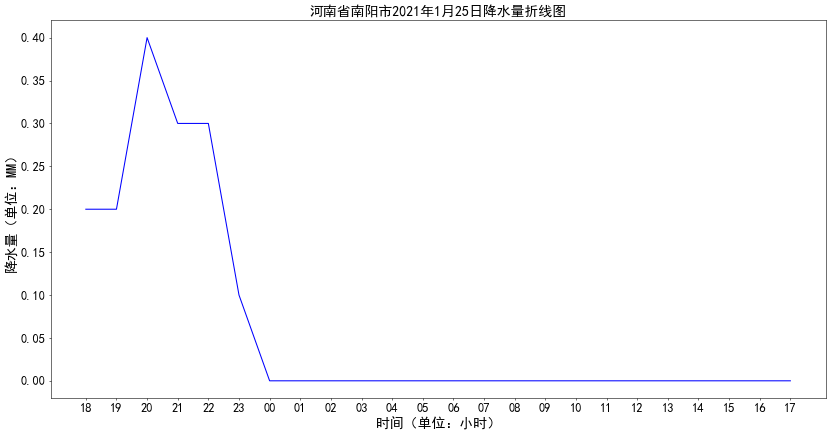

In [127]:
fig = plt.figure(figsize=(20,10),dpi=50) 

x= list(df1["小时"])
y= list(df1["降水量"])

y=list(map(float,y))#将字符串改为int
plt.gca().invert_xaxis()#对x轴翻转

plt.tick_params(labelsize=18)
plt.plot(x,y,"b")

plt.xlabel("时间（单位：小时）",fontsize=20)
plt.ylabel("降水量（单位：MM）",fontsize=20)
plt.title("河南省南阳市2021年1月25日降水量折线图",fontsize=20)
plt.show()

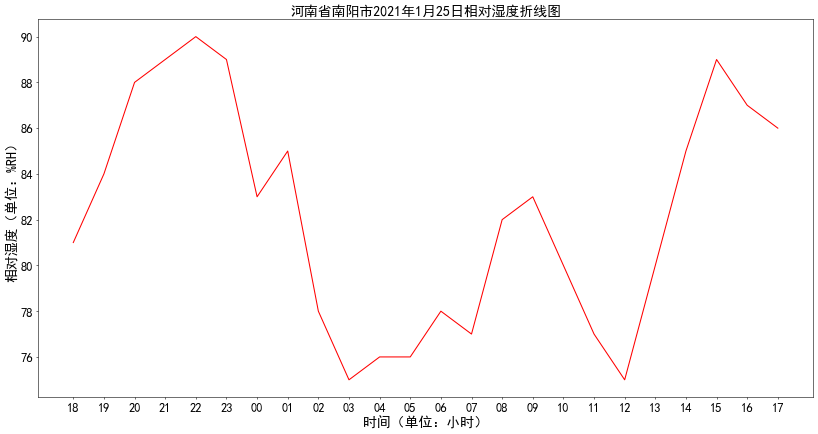

In [128]:
fig = plt.figure(figsize=(20,10),dpi=50) 

x= list(df1["小时"])
y= list(df1["相对湿度"])

y=list(map(int,y))#将字符串改为int
plt.gca().invert_xaxis()#对x轴翻转

plt.tick_params(labelsize=18)
plt.plot(x,y,"r")

plt.xlabel("时间（单位：小时）",fontsize=20)
plt.ylabel("相对湿度（单位：%RH）",fontsize=20)
plt.title("河南省南阳市2021年1月25日相对湿度折线图",fontsize=20)
plt.show()

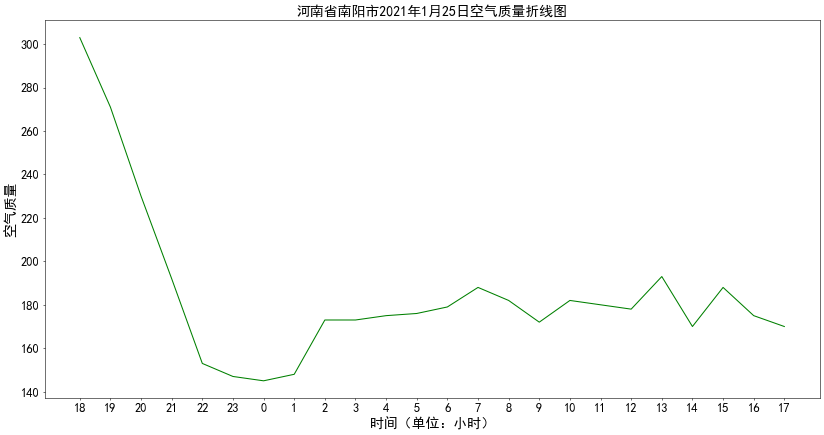

In [134]:
fig = plt.figure(figsize=(20,10),dpi=50) 

x= list(df1["小时"])
y= list(df1["空气质量"])

y=list(map(int,y))#将字符串改为int
plt.gca().invert_xaxis()#对x轴翻转

plt.tick_params(labelsize=18)
plt.plot(x,y,"g")

plt.xlabel("时间（单位：小时）",fontsize=20)
plt.ylabel("空气质量",fontsize=20)
plt.title("河南省南阳市2021年1月25日空气质量折线图",fontsize=20)
plt.show()

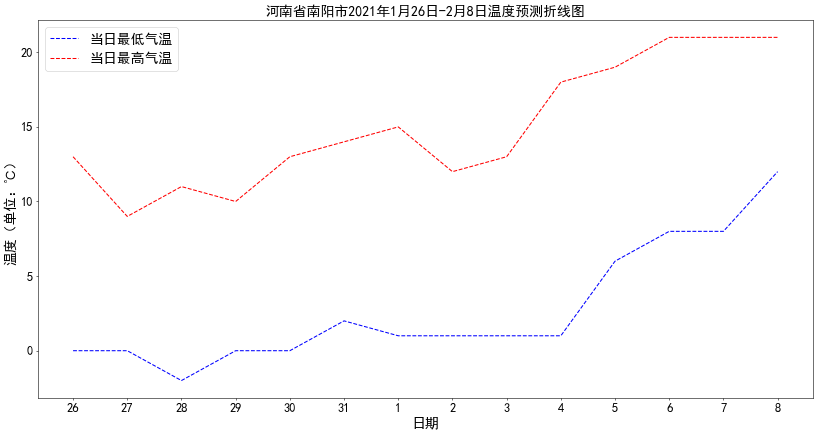

In [140]:
fig = plt.figure(figsize=(20,10),dpi=50) 

x= list(df14["日期"])
y1= list(df14["最低气温"])
y2= list(df14["最高气温"])

y1=list(map(int,y1))#将字符串改为int
y2=list(map(int,y2))

plt.tick_params(labelsize=18)
plt.plot(x,y1,"b--",label="当日最低气温")
plt.plot(x,y2,"r--",label="当日最高气温")


plt.xlabel("日期",fontsize=20)
plt.ylabel("温度（单位：℃）",fontsize=20)
plt.title("河南省南阳市2021年1月26日-2月8日温度预测折线图",fontsize=20)
plt.legend(fontsize=20)
plt.show()